In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

In [2]:
prefix = "HH_object_ATTP_"
filename = "object_id_attp_filtered_combined.txt"
s = open(filename, "r").readlines()    

In [3]:
raw_pr = []
raw_mem = []
raw_time = []
raw_final_mem = []
ln = 0
query_type = ""
flagFinal = False
for line in s:
    if line.startswith("START_OF_FINAL_STATS_REPORT"):
        flagFinal = True
    if line.startswith("Stats request at line"):
        ln = int(re.findall("\d+", line)[1])
        flagFinal = False
    if line.find(" timers") != -1:
        query_type = line.strip().split(" ")[0]
    if line.find(" ms = ") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            raw_time.append(sketch + [ln, query_type, int(t[1].split("=")[1].strip()[:-3])])
    if line.find("prec") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            sketch = [sketch[0], ''.join(sketch[1:])]
            pr_info = t[1].split(",")
            try:
                pr_info = list(map(lambda x: float(x.split('=')[2].strip()), pr_info))
            except ZeroDivisionError:
                continue
            raw_pr.append(sketch + [pr_info[0], pr_info[1]])
    if line.find("MB") != -1:
        t = line.strip().split(':')
        if t[0] != "EXACT_HH":
            sketch = t[0].split('-')
            t = [sketch[0], ''.join(sketch[1:]), ln, int(t[1].split("=")[0].strip()[:-2])]
            if flagFinal:
                raw_final_mem.append(t)
            else:
                raw_mem.append(t)

In [4]:
mem = pd.DataFrame(raw_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
mem

,Sketch,Param,Stream Size,Memory Usage (B)
0,SAMPLING,ss500000,13528041,128005024
1,PCM_HH,logU17e0.01d0.01D2000,13528041,7004928
2,CMG,e0.010000,13528041,319752
3,SAMPLING,ss500000,27056082,128005024
4,PCM_HH,logU17e0.01d0.01D2000,27056082,10833344
...,...,...,...,...
1795,PCM_HH,logU17e0.04d0.01D2000,1339276059,121548784
1796,CMG,e0.001000,1339276059,4220952
1797,SAMPLING,ss10000,1352804100,2920096
1798,PCM_HH,logU17e0.04d0.01D2000,1352804100,125367376


In [5]:
time = pd.DataFrame(raw_time, columns = ["Sketch", "Param", "Stream Size", "Type", "Time (ms)"])
time_processed = pd.merge(time, mem, on = ["Sketch", "Param", "Stream Size"]).drop_duplicates()
utime = time_processed[time_processed["Type"] == "Update"]
utime

,Sketch,Param,Stream Size,Type,Time (ms),Memory Usage (B)
0,SAMPLING,ss500000,13528041,Update,1364,128005024
2,PCM_HH,logU17e0.01d0.01D2000,13528041,Update,40339,7004928
4,CMG,e0.010000,13528041,Update,4312,319752
6,SAMPLING,ss500000,27056082,Update,2506,128005024
8,PCM_HH,logU17e0.01d0.01D2000,27056082,Update,81048,10833344
...,...,...,...,...,...,...
3620,PCM_HH,logU17e0.04d0.01D2000,1339276059,Update,4294664,121548784
3622,CMG,e0.001000,1339276059,Update,418595,4220952
3624,SAMPLING,ss10000,1352804100,Update,109858,2920096
3628,PCM_HH,logU17e0.04d0.01D2000,1352804100,Update,4335982,125367376


In [6]:
pr = pd.DataFrame(raw_pr, columns = ["Sketch", "Param", "Precision", "Recall"])
final_mem = final_mem = pd.DataFrame(raw_final_mem, columns = ["Sketch", "Param", "Stream Size", "Memory Usage (B)"])
pr = pd.merge(pr, final_mem, on = ["Sketch", "Param"]).groupby(["Sketch", "Param", "Memory Usage (B)"]).mean().drop("Stream Size", 1)
pr = pd.DataFrame(pr.to_records())
pr

,Sketch,Param,Memory Usage (B),Precision,Recall
0,CMG,e0.001000,4206160,0.900000,1.000000
1,CMG,e0.002000,2220496,0.900000,1.000000
2,CMG,e0.004000,1211832,0.950000,1.000000
3,CMG,e0.006000,855312,0.870000,1.000000
4,CMG,e0.008000,721208,0.760000,1.000000
5,CMG,e0.010000,556880,0.800000,1.000000
6,PCM_HH,logU17e0.001d0.01D2000,201638580,NaN,0.000000
7,PCM_HH,logU17e0.003d0.01D2000,174333316,NaN,0.000000
8,PCM_HH,logU17e0.007d0.01D2000,162631676,NaN,0.000000
9,PCM_HH,logU17e0.01d0.01D2000,149789696,0.000000,0.000000


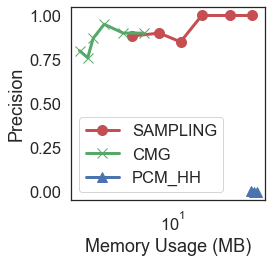

In [15]:
fig, ax = plt.subplots(figsize = (4, 4))
sketch_type = ["SAMPLING", "CMG", "PCM_HH"]
sketch_param = {
    "PCM_HH" : ["logU17e0.001d0.01D2000", "logU17e0.02d0.01D2000"],
    "SAMPLING" : ["ss50000", "ss10000"],
    "CMG" : ["e0.001000", "e0.010000"],
}
        
linestyles = ["-", "--", "."]
colors = ["r", "g", "b"]
markers = ["o", "x", "^"]
ms = 10
lw = 3

cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[3], color = colors[cnt], marker = markers[cnt], label = sk, markersize = ms, linewidth = lw)
    cnt += 1
ax.legend()
ax.set_xscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Precision")
plt.tight_layout()
plt.savefig(prefix + 'precision.pdf')

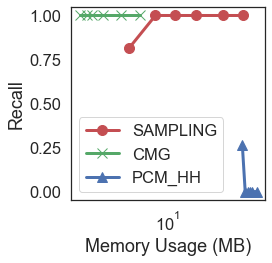

In [16]:
fig, ax = plt.subplots(figsize = (4, 4))
cnt = 0
for sk in sketch_type:
    dat = pr[pr["Sketch"] == sk].sort_values(by = "Memory Usage (B)").transpose().to_numpy()
    plt.plot(dat[2] / 1048576.0, dat[4], color = colors[cnt], marker = markers[cnt], label = sk, markersize = ms, linewidth = lw)
    cnt += 1
ax.legend()

ax.set_xscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Recall")
plt.tight_layout()
plt.savefig(prefix + 'recall.pdf')

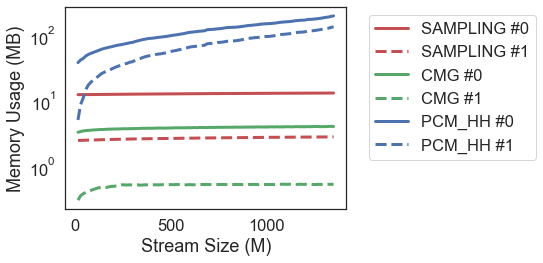

In [17]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0

for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = mem[(mem["Sketch"] == sk) & (mem["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[2] / 1000000.0, dat[3] / 1048576.0, label = "%s #%d" % (sk, cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))

ax.set_yscale("log")
ax.set_xlabel("Stream Size (M)")
ax.set_ylabel("Memory Usage (MB)")
plt.tight_layout()
plt.savefig(prefix + 'mem.pdf')

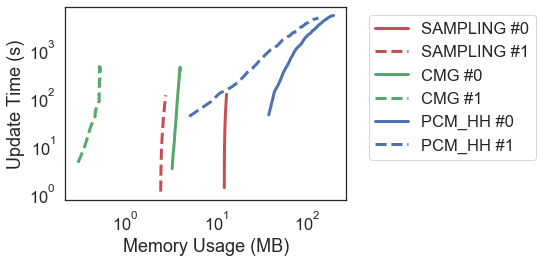

In [19]:
fig, ax = plt.subplots(figsize = (8, 4))
cnt = 0
for sk in sketch_type:
    cnt0 = 0
    for p in sketch_param[sk]:
        dat = utime[(utime["Sketch"] == sk) & (utime["Param"] == p)].sort_values(by = "Stream Size").transpose().to_numpy()
        plt.plot(dat[-1] / 1048576.0, dat[-2] / 1000.0, label = "%s #%d" % (sk, cnt0), markersize = ms, color = colors[cnt], linestyle = linestyles[cnt0], linewidth = lw)
        cnt0 += 1
    cnt += 1

ax.legend(bbox_to_anchor=(1.05, 1))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Memory Usage (MB)")
ax.set_ylabel("Update Time (s)")
plt.tight_layout()
plt.savefig(prefix + 'time.pdf')